# **任务7 卷积单目标检测 CNN - Single Object Detection**

## 1. **定义模型**

目标检测任务作为经典的视觉任务，有很多很多优化后的模型结构，为了不让后续记录变得冗长，这里尽可能展示足够的基础模型。

这次任务以单目标的目标检测为主，因为多目标涉及torch模型之外的算法。

一个无分支的神经网络直接输出类别和边界框信息，两个类别就需要两个维度作为概率得分，四个类别作为边界框信息，一共六个维度输出。

In [29]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(CNN, self).__init__()
        self.img_encoder = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()

        self.output_layer = nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.img_encoder(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x

## 2. **数据生成**

除了边界框还需要一个新的 y 作为类别标注

输入数据形状: torch.Size([1024, 3, 128, 128])
输入批次数量: 8 	批次形状: torch.Size([128, 3, 128, 128])
类别标签形状: torch.Size([1024])
输入批次数量: 8 	批次形状: torch.Size([128])
边界框标签形状: torch.Size([1024, 4])
输入批次数量: 8 	批次形状: torch.Size([128, 4])


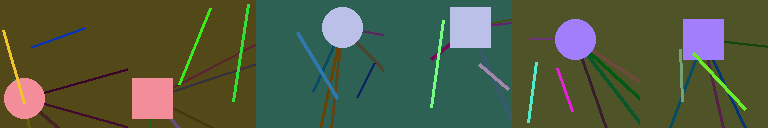

In [30]:
import random
from PIL import Image, ImageDraw
import torchvision.transforms as transforms

def get_data(data_size, img_size, get_all_img=False):
    train_images = []
    # 用于存储对应类别标签的列表
    train_class_labels = []
    train_boundary_labels = []
    show_img_list = []
    for x in range(data_size // 2):
        b_col = (random.randint(0, 120), random.randint(0, 120), random.randint(0, 120))
        mid_loc = (random.randint(20, img_size-20), random.randint(20, img_size-20))
        r = 20
        loc_0, lod_1 = (mid_loc[0]-r, mid_loc[1]-r), (mid_loc[0]+r, mid_loc[1]+r)
        file_col = (random.randint(120, 255), random.randint(120, 255), random.randint(120, 255))

        image0 = Image.new('RGB', (img_size, img_size), b_col)
        image1 = Image.new('RGB', (img_size, img_size), b_col)

        draw0 = ImageDraw.Draw(image0)
        for _ in range(5):
            draw0.line([mid_loc, (random.randint(0, 255), random.randint(0, 255))],
                       fill=(random.randint(0, 120), random.randint(0, 120), random.randint(0, 120)), width=3)
        draw0.ellipse((loc_0, lod_1), fill=file_col)
        for _ in range(2):
            draw0.line([(random.randint(0, img_size), random.randint(0, img_size)), (random.randint(20, img_size - 20), random.randint(20, img_size - 20))], fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), width=3)

        draw1 = ImageDraw.Draw(image1)
        for _ in range(5):
            draw1.line([mid_loc, (random.randint(0, 255), random.randint(0, 255))],
                       fill=(random.randint(0, 120), random.randint(0, 120), random.randint(0, 120)), width=3)
        draw1.rectangle((loc_0, lod_1), fill=file_col)
        for _ in range(2):
            draw1.line([(random.randint(0, img_size), random.randint(0, img_size)), (random.randint(20, img_size - 20), random.randint(20, img_size - 20))], fill=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), width=3)

        loc_0, lod_1 = (mid_loc[0] - r - 10, mid_loc[1] - r - 10), (mid_loc[0] + r + 10, mid_loc[1] + r + 10)
        mid_x, mid_y = abs(lod_1[0] + loc_0[0]) / 2 / img_size, abs(lod_1[1] + loc_0[1]) / 2 / img_size
        w_x, h_y = abs(lod_1[0] - loc_0[0]) / img_size, abs(lod_1[1] - loc_0[1]) / img_size

        if len(show_img_list) < 6 or get_all_img:
            show_img_list.append(image0)
            show_img_list.append(image1)

        # 组合变换操作
        transform = transforms.Compose([
            transforms.ToTensor(),
            # 归一化操作，使用上面定义的均值和标准差
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image0 = transform(image0)
        train_images.append(image0)
        train_boundary_labels.append([mid_x, mid_y, w_x, h_y])
        train_class_labels.append(0)

        image1 = transform(image1)
        train_images.append(image1)
        train_boundary_labels.append([mid_x, mid_y, w_x, h_y])
        train_class_labels.append(1)

    # 转换为张量
    train_images, train_class_labels, train_boundary_labels = torch.stack(train_images), torch.tensor(train_class_labels), torch.tensor(train_boundary_labels)
    return train_images, train_class_labels, train_boundary_labels, show_img_list

# 划分批次
def split_batch(data, batch_size):
    # 核心操作：沿第一个维度（dim=0）分割，保留后续所有维度
    split_tensors = torch.split(data, batch_size, dim=0)
    # 转为列表返回（torch.split返回tuple，列表更易操作）
    return list(split_tensors)

# 训练数据
img_size = 128
batch_size = 128
train_x, train_class, train_boundary, show_img_list = get_data(1024, img_size)
train_x_batch = split_batch(train_x, batch_size)
train_class_batch = split_batch(train_class, batch_size)
train_boundary_batch = split_batch(train_boundary, batch_size)
# 验证数据
val_x, val_class, val_boundary, _ = get_data(128, img_size)
# 测试数据
test_x, test_class, test_boundary, test_img = get_data(6, img_size, get_all_img=True)
print('输入数据形状:', train_x.shape)
print('输入批次数量:', len(train_x_batch), '\t批次形状:', train_x_batch[0].shape)
print('类别标签形状:', train_class.shape)
print('输入批次数量:', len(train_class_batch), '\t批次形状:', train_class_batch[0].shape)
print('边界框标签形状:', train_boundary.shape)
print('输入批次数量:', len(train_boundary_batch), '\t批次形状:', train_boundary_batch[0].shape)

m = 0
combined = Image.new('RGB', (img_size*len(show_img_list), img_size))
for img in show_img_list:
    combined.paste(img, (m, 0))    # 把a贴到画布左侧
    m += img_size
combined

## 3. 模型训练

### 3.1 实例化模型、损失函数、优化器

本次任务虽然是一个复合问题，需要使用两种损失函数，分别对应分类和回归 `nn.CrossEntropyLoss()` `nn.MSELoss()`。

由于图像的计算比较复杂，所以通常需要使用显卡并行计算，使用 `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` 来判断显卡的cuda设备是否可用，然后使用 `to` 方法将数据和模型全都转到cuda上计算.

数据和模型的设备必须同步，不然会报错。

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(3, 6, 32).to(device)
criterion_class = nn.CrossEntropyLoss()
criterion_boundary = nn.MSELoss()
optimizer_basic = torch.optim.Adam(model.parameters(), lr=0.0005)

### 3.2 **迭代训练**

两个损失是分别计算的，可以直接求和反向传播，但有可能导致梯度值较大从而导致训练不稳定。

常见操作是取平均值，不过对于目标检测任务来说，类别往往收敛更快，可以加权求和，给类别损失更小的权重。

由于基础模型的输出将两个任务混在了一起，需要拆分计算损失

In [32]:
epochs = 50
for epoch in range(epochs):
    sum_loss = None
    model.train()
    for i in range(len(train_x_batch)):
        x = train_x_batch[i].to(device)
        y_class = train_class_batch[i].to(device)
        y_boundary = train_boundary_batch[i].to(device)
        # 前向传播，得到预测值
        output = model(x)
        output_class = output[:,0:2]
        output_boundary = output[:,2:]
        # 计算损失
        loss_class = criterion_class(output_class, y_class)
        loss_boundary = criterion_boundary(output_boundary, y_boundary)
        sum_loss = loss_class * 0.4 + loss_boundary * 0.6
        # 梯度清零，因为在每次反向传播前都要清除之前累积的梯度
        optimizer_basic.zero_grad()
        # 反向传播，计算梯度
        sum_loss.backward()
        # 更新权重和偏置
        optimizer_basic.step()

    val_x = val_x.to(device)
    val_y_class = val_class.to(device)
    val_y_boundary = val_boundary.to(device)
    model.eval()
    output = model(val_x)
    output_class = output[:,0:2]
    output_boundary = output[:,2:]
    val_loss_class = criterion_class(output_class, val_y_class)
    val_loss_boundary = criterion_boundary(output_boundary, val_y_boundary)
    val_sum_loss = val_loss_class * 0.4 + val_loss_boundary * 0.6

    # 更改验证逻辑为适合分类任务的准确率和召回率
    if (epoch + 1) % 10 == 0:
        print(f'[epoch {epoch+1}]loss:', sum_loss.item())
        print(f'\t val loss:', val_sum_loss.item())


[epoch 10]loss: 0.264097660779953
	 val loss: 0.26638302206993103
[epoch 20]loss: 0.011075939983129501
	 val loss: 0.012519557029008865
[epoch 30]loss: 0.003594012698158622
	 val loss: 0.004804074298590422
[epoch 40]loss: 0.0017145542660728097
	 val loss: 0.002797603840008378
[epoch 50]loss: 0.001180143910460174
	 val loss: 0.0022610616870224476


### 3.3 **测试模型**

使用 `model.eval()` 将模型改为测试模式，避免自动的梯度计算增加额外的计算量。

输入数据: torch.Size([3, 128, 128])
目标类别结果: 0
类别预测结果: 0
目标边界框结果: [0.7578125, 0.3828125, 0.46875, 0.46875]
边界框预测结果: [0.7770252823829651, 0.3819314241409302, 0.45425984263420105, 0.4198061525821686]
输入数据: torch.Size([3, 128, 128])
目标类别结果: 1
类别预测结果: 1
目标边界框结果: [0.7578125, 0.3828125, 0.46875, 0.46875]
边界框预测结果: [0.8439505696296692, 0.4151344895362854, 0.49174776673316956, 0.5289294123649597]
输入数据: torch.Size([3, 128, 128])
目标类别结果: 0
类别预测结果: 0
目标边界框结果: [0.5078125, 0.75, 0.46875, 0.46875]
边界框预测结果: [0.4871574640274048, 0.7143586277961731, 0.47635093331336975, 0.449458509683609]
输入数据: torch.Size([3, 128, 128])
目标类别结果: 1
类别预测结果: 1
目标边界框结果: [0.5078125, 0.75, 0.46875, 0.46875]
边界框预测结果: [0.48606833815574646, 0.7538569569587708, 0.44479721784591675, 0.4321673810482025]
输入数据: torch.Size([3, 128, 128])
目标类别结果: 0
类别预测结果: 0
目标边界框结果: [0.625, 0.75, 0.46875, 0.46875]
边界框预测结果: [0.6920760869979858, 0.6878515481948853, 0.5499460697174072, 0.471307635307312]
输入数据: torch.Size([3, 128, 128])
目标类别结果: 1
类别预测结果: 1
目标边界

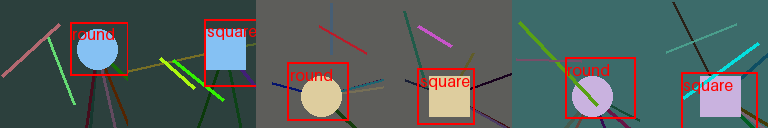

In [33]:
model.eval()
class_label_index = {0: 'round', 1: 'square'}
test_x = test_x.to(device)
output = model(test_x)

output_class = output[:, 0:2]
output_boundary = output[:, 2:]

m = 0
test_combined = Image.new('RGB', (img_size*len(test_img), img_size))
for i in range(len(test_x)):
    img = test_img[i]
    draw = ImageDraw.Draw(img)

    class_id = torch.argmax(output_class, dim=1)[i].item()

    mid_x, mid_y, range_w, range_h = output_boundary[i].to('cpu').tolist()

    loc_x0 = mid_x * img_size - range_w * img_size / 2
    loc_y0 = mid_y * img_size - range_h * img_size / 2
    loc_x1 = mid_x * img_size + range_w * img_size / 2
    loc_y1 = mid_y * img_size + range_h * img_size / 2

    draw.rectangle(((loc_x0, loc_y0), (loc_x1, loc_y1)), outline=(255, 0, 0), width=2)
    draw.text((loc_x0 + 2, loc_y0 + 2), text=class_label_index[class_id], fill=(255, 0, 0), font_size=16)

    test_combined.paste(img, (m, 0))    # 把a贴到画布左侧
    m += img_size
    print('输入数据:', test_x[i].shape)
    print('目标类别结果:', test_class[i].to('cpu').item())
    print('类别预测结果:', class_id)
    print('目标边界框结果:', test_boundary[i].to('cpu').tolist())
    print('边界框预测结果:', output_boundary[i].to('cpu').tolist())


test_combined

## 5. **总结**

目标检测是一个很经典的视觉算法，YOLO框架有更成熟和高效的方法来解决这个任务，通常情况下我们不需要像这样自己构建模型，但作为第一个混合任务，目标检测算法非常有启发性。